In [1]:
import alpdesign
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import optimizers

### Initialize data

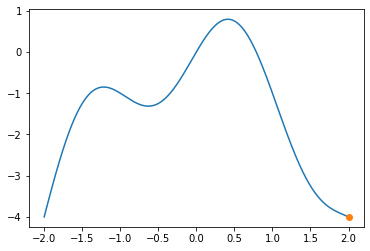

In [2]:
x = np.linspace(-2,2, 1000)
reps = np.array([2.0]).reshape(-1,1)
label_fxn = lambda x: np.sin(x * np.pi) - x ** 2
labels = label_fxn(reps)
plt.plot(x,  label_fxn(x))
plt.plot(reps, labels, 'o')

In [3]:
(4, *reps[0].shape)

(4, 1)

In [4]:
config = alpdesign.EnsembleBlockConfig()
forward_t, full_forward_t, seq_t = alpdesign.build_e2e(config)

In [5]:

#batch_size = 16
def loop(key, reps, params):
    labels = label_fxn(reps)
    key, key2 = jax.random.split(key)
    best_v, params, train_loss, bo_loss = alpdesign.alg_iter(
        key2, reps, labels, full_forward_t, forward_t, config,
        )
    #final_vec, params, train_loss, bo_loss = alpdesign.alg_iter(key, reps, labels, forward_fxn_t,full_forward_fxn_t,config)
    # compute plot
    yhat_mu, yhat_std = [], []
    eis = []
    plot_forward = partial(forward_t.apply, params, None)
    ei_forward = partial(forward_t.apply, params)
    for xi in x:
        v = plot_forward(xi[np.newaxis])
        yhat_mu.append(float(v[0]))
        yhat_std.append(jnp.sqrt(float(v[1])))
        ei = -alpdesign.mlp.neg_bayesian_ei(key, ei_forward, xi, labels, 1e-1)
        eis.append(ei)
    # add new label
    plt.figure()
    plt.plot(x, eis)
    #plt.plot(train_loss)
    plt.show()
    reps = jnp.concatenate((reps, best_v[np.newaxis]))    
    return key, reps, yhat_mu, yhat_std, best_v, params
    
    

0


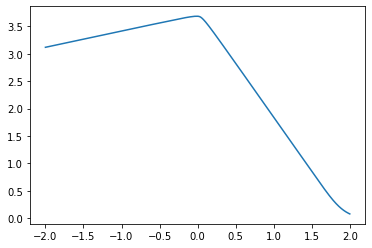

[[ 2.        ]
 [-0.00884275]]
1


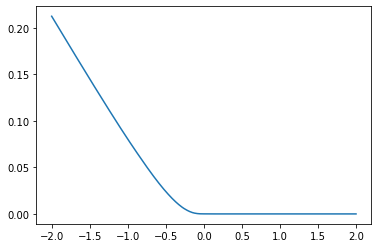

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]]
2


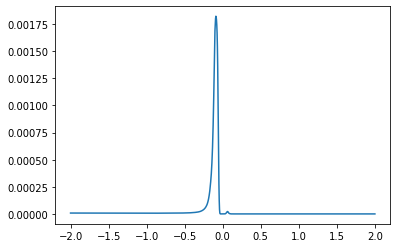

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]]
3


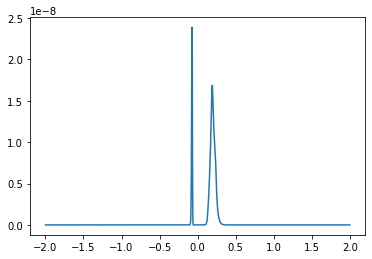

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]]
4


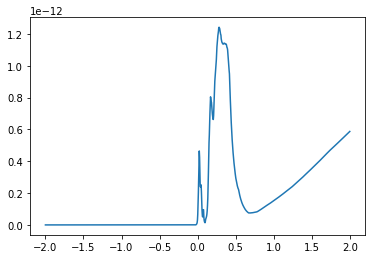

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]]
5


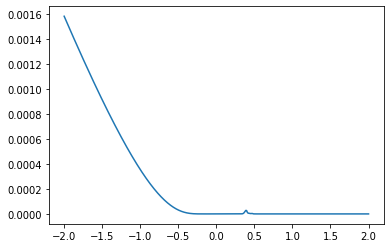

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]]
6


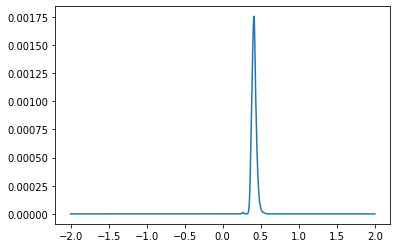

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]]
7


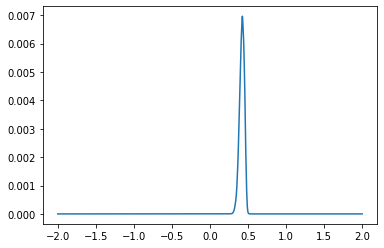

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]]
8


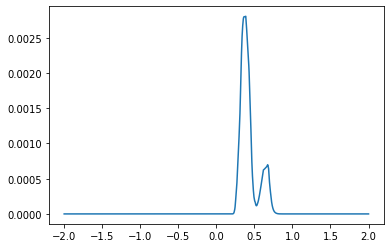

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]]
9


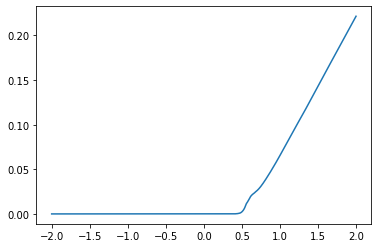

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]]
10


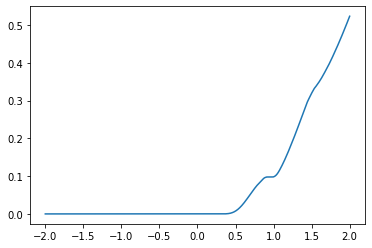

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]]
11


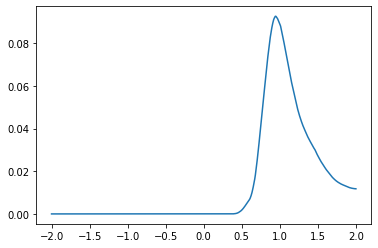

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]]
12


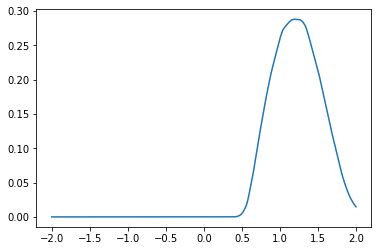

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]]
13


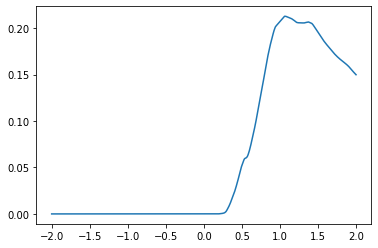

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]]
14


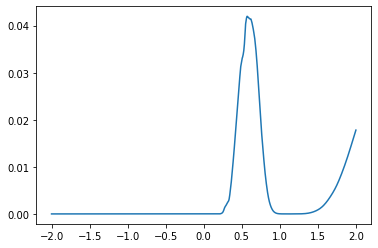

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]]
15


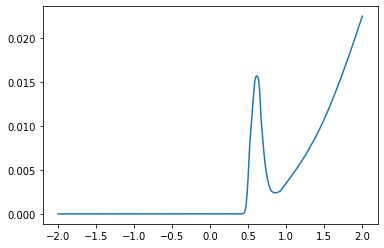

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]
 [ 2.4961855 ]]
16


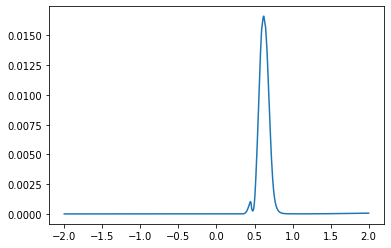

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]
 [ 2.4961855 ]
 [ 0.61791956]]
17


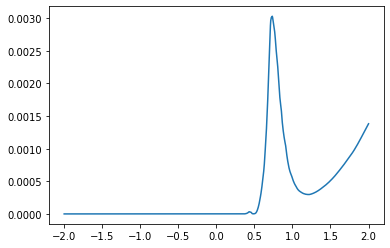

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]
 [ 2.4961855 ]
 [ 0.61791956]
 [ 0.7360372 ]]
18


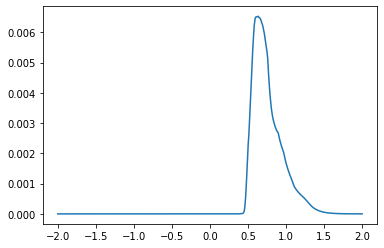

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]
 [ 2.4961855 ]
 [ 0.61791956]
 [ 0.7360372 ]
 [ 0.63333035]]
19


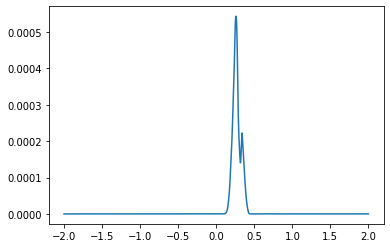

[[ 2.        ]
 [-0.00884275]
 [-6.459047  ]
 [-0.09097186]
 [-0.0136001 ]
 [ 0.35012856]
 [-6.536445  ]
 [ 0.4125509 ]
 [ 0.42637306]
 [ 0.38321146]
 [ 5.8431277 ]
 [ 7.017544  ]
 [ 7.783792  ]
 [ 1.2002385 ]
 [ 1.061861  ]
 [ 7.6073365 ]
 [ 2.4961855 ]
 [ 0.61791956]
 [ 0.7360372 ]
 [ 0.63333035]
 [ 0.25917953]]


In [6]:
key = jax.random.PRNGKey(0)

yhat_mus = []
yhat_stds = []
final_vecs = []
repss = []
params = None
for i in range(20):
    print(i)
    key, reps, yhat_mu, yhat_std, final_vec, params= loop(key, reps, params)
    print(reps)
    yhat_mus.append(yhat_mu)
    yhat_stds.append(yhat_std)
    final_vecs.append(final_vec)
    repss.append(reps)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


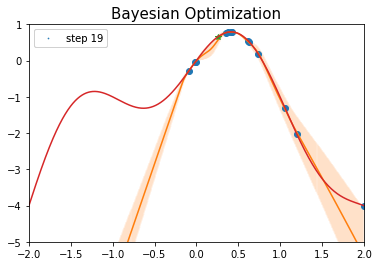

In [7]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(20):
    plt.plot(np.squeeze(repss[i][:-1]), label_fxn(np.squeeze(repss[i][:-1])), 'o', color='C0')
    plt.plot(x, yhat_mus[i], color='C1')
    plt.xlim(-2,2)
    #print(x.shape)
    #print()
    print(i)
    plt.ylim([-5, 1])
    plt.plot(final_vecs[i][0], label_fxn(final_vecs[i][0]), '*', color='C2')
    plt.plot(x, label_fxn(x), color='C3')
    plt.errorbar(x, yhat_mus[i], yerr=yhat_stds[i], color='C1', alpha=0.05)
    plt.legend(['step %d' % (i)] , markerscale=0.1)
    plt.title('Bayesian Optimization', fontsize=15)
    camera.snap()
animation = camera.animate(interval = 2000, repeat = True,
                           repeat_delay = 500)
animation.save('BO_newloss.gif', writer = 'imagemagick', dpi=180)